In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
## Check here for formula https://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x
def sigmoid(v):
    return 1/(1 + np.exp(-v))

def sigmoid_prime(v):
    return sigmoid(v) * (1 - sigmoid(v))

def rmse(target, output):
    ## Make sure target and output have the same shape
    ## Assuming batch processing: shape should be (num_outputs, batch_size)
    target = np.array(target)
    output = np.array(output)
    return (np.mean((target - output) ** 2)) ** 0.5

In [3]:
## Check here for formula https://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x
def sigmoid(v):
    return 1/(1 + np.exp(-v))

def sigmoid_prime(v):
    return sigmoid(v) * (1 - sigmoid(v))

class Net:
    def __init__(self, input_shape: int, num_of_neurons_per_layer: list, lr: float, momentum: float, min_grad: float):
        self.input_shape = input_shape
        self.num_of_neurons_per_layer = num_of_neurons_per_layer
        self.lr = lr
        self.momentum = momentum
        self.min_grad = min_grad

        self.weights = None
        self.bias = None
        self.activations = None

        self.prev_dW = None
        self.prev_db = None

        self.updated_weights = None
        self.updated_bias = None

    ## Initialize weights and biases
    def initialize_weights(self):
        temp = self.input_shape
        weights, bias = [], []

        for neuron in self.num_of_neurons_per_layer: 
            limit = np.sqrt(6 / (temp + neuron))
            weights.append(np.random.uniform(-limit, limit, (neuron, temp)).astype(np.float32))
            bias.append(np.zeros((neuron, 1), dtype=np.float32))
            temp = neuron

        self.weights, self.bias = weights, bias

    ## Feed forward
    def feed_forward(self, inputs):
        a = inputs.astype(np.float32)
        last_activation = a
        self.activations = [last_activation]

        for w, b in zip(self.weights, self.bias):
            z = w @ last_activation + b 
            last_activation = sigmoid(z)
            self.activations.append(last_activation)
        
        return self.activations

    def backward_pass(self, target, epoch):
        num_layers = len(self.weights)
        
        ## Initialize updated weights/biases and gradients
        updated_weights = [np.zeros_like(w) for w in self.weights]
        updated_bias = [np.zeros_like(b) for b in self.bias]
        if epoch == 0:
            self.prev_dW = [np.zeros_like(w) for w in self.weights]
            self.prev_db = [np.zeros_like(b) for b in self.bias]

        total_grad_norm = 0
        last_delta = None
        
        ## Process layers in reverse order
        for i in range(num_layers - 1, -1, -1):
            current_activation = self.activations[i + 1]  
            prev_activation = self.activations[i]
            
            ## Calculate delta
            if last_delta is None:  # Output layer
                delta = (current_activation - target) * current_activation * (1 - current_activation)
            else:
                delta = (self.weights[i + 1].T @ last_delta) * current_activation * (1 - current_activation)

            total_grad_norm += np.linalg.norm(delta)
            
            ## Compute gradients
            dW = delta @ prev_activation.T
            db = np.sum(delta, axis=1, keepdims=True)
            
            ## Update weights and biases with momentum
            updated_weights[i] = self.weights[i] - (self.lr * dW + self.momentum * self.prev_dW[i])
            updated_bias[i] = self.bias[i] - (self.lr * db + self.momentum * self.prev_db[i])
            
            ## Store deltas for momentum
            self.prev_dW[i] = dW
            self.prev_db[i] = db
            
            last_delta = delta
        
        ## Update weights and biases
        self.weights = updated_weights
        self.bias = updated_bias

        should_stop = total_grad_norm < self.min_grad
        return should_stop

    def predict(self, inputs):
        activations = self.feed_forward(inputs)
        return activations[-1]
    
    def save_weights(self, filename):
        weights_and_biases = [
                                self.weights,
                                self.bias]  
        np.save(filename, np.array(weights_and_biases, dtype=object), allow_pickle=True)
    
    def load_weights(self, filename):
        weights_and_biases = np.load(filename, allow_pickle=True)
        self.weights = weights_and_biases[0]
        self.bias = weights_and_biases[1]

In [4]:
# inputs = np.array([[1], [1]])
# target = np.array([[2], [2]])
# ## Where the value is the number of neurons in that layer 
# ## and the number of layers is the length of the list
# num_of_neutrons_per_layer = [5, 2] 
# lr = 0.009
# mc = 0.9
# min_grad = 3e-4

In [5]:
# def train(inputs, target, input_shape, num_of_neutrons_per_layer, lr, mc, min_grad, epochs):
#     net = Net(input_shape, num_of_neutrons_per_layer, lr, mc, min_grad)
#     net.initialize_weights()

#     for epoch in range(epochs):
#         activations = net.feed_forward(inputs)
#         loss = rmse(target,activations[-1]) 
        
#         early_stop = net.backward_pass(target, epoch)
#         print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.6f}")
#         if early_stop:
#             break
#     return net

# epochs = 1000
# input_shape = inputs.shape[0]
# net = train(inputs, 
#             target, 
#             input_shape,
#             num_of_neutrons_per_layer, 
#             lr, 
#             mc, 
#             min_grad, 
#             epochs)   

# net.predict(target)

In [6]:
def normilize(training_data, test_data):
    training_data = training_data.drop_duplicates()

    training_array = training_data.to_numpy()
    test_array = test_data.to_numpy()

    trainingMin = np.min(training_array[:,:], axis= 0) ##The minimum values in each column
    trainingMax = np.max(training_array[:,:], axis= 0 ) ##The maximum values in each column
    trainingNorm = (training_array - trainingMin) / (trainingMax - trainingMin) ## normalization of the dataset
    testNorm = (test_array - trainingMin) / (trainingMax - trainingMin)

    scaleddf = pd.DataFrame({'xDist': trainingNorm[:, 0], 'yDist': trainingNorm[:, 1], 
                             'xVel': trainingNorm[:, 2], 'yVel': trainingNorm[:, 3]})

    scaleddf.to_csv('scaledData.csv', encoding='utf-8', index=False)


    training_xDist = trainingNorm[:,0]
    training_yDist = trainingNorm[:,1]
    training_input_data = np.column_stack((training_xDist, training_yDist)) ##The processed input data


    training_xVel = trainingNorm[:,2]
    training_yVel = trainingNorm[:,3]
    training_output_data = np.column_stack((training_xVel, training_yVel)) ##The processed output data


    test_xDist = testNorm[:,0]
    test_yDist = testNorm[:,1]
    test_input_data = np.column_stack((test_xDist, test_yDist)) 


    test_xVel = testNorm[:,2]
    test_yVel = testNorm[:,3]    
    test_output_data = np.column_stack((test_xVel, test_yVel)) 

    return training_input_data, training_output_data, test_input_data, test_output_data


In [7]:
## Train from CSV
def train_from_csv(model, input_array, target_array, val_input_array, val_target_array, epochs):
    ## https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    def unison_shuffled_copies(inputs, targets):
        assert len(inputs) == len(targets)
        p = np.random.permutation(len(inputs))
        return [inputs[i] for i in p], [targets[i] for i in p]

    ## Format inputs and targets consistently
    inputs = [np.array(row).reshape(2, 1) for row in input_array]
    targets = [np.array(row).reshape(2, 1) for row in target_array]

    val_inputs = [np.array(row).reshape(2, 1) for row in val_input_array]
    val_targets = [np.array(row).reshape(2, 1) for row in val_target_array]

    ## Loss strorage
    training_losses = []
    validation_losses = []
    best_loss = float('inf')
    
    for epoch in range(epochs):
        if epoch > 0:  ## Shuffle after first epoch
            inputs, targets = unison_shuffled_copies(inputs, targets)
        
        training_total_loss = 0.0
        val_total_loss = 0.0
        
        for input_sample, target_sample in zip(inputs, targets):
            ## Ensure shapes are correct
            input_sample = np.array(input_sample, dtype=np.float64)
            target_sample = np.array(target_sample, dtype=np.float64)
            
            ## Forward pass
            activations = model.feed_forward(input_sample)
            
            ## Calculate mse loss
            training_loss = rmse(target_sample, activations[-1])
            training_total_loss += training_loss
            
            ## Backward pass
            early_stop = model.backward_pass(target_sample, epoch)
            
        if early_stop:
            print(f"Early stopping triggered in epoch {epoch + 1}")
            model.save_weights("best_weights.npy")
            return model
        
        ## Validate
        for val_input, val_target in zip(val_inputs, val_targets):
            val_input = np.array(val_input, dtype=np.float64)
            val_target = np.array(val_target, dtype=np.float64)

            prediction = model.predict(val_input)

            val_loss = rmse(val_target, prediction)
            val_total_loss += val_loss

        ## Calculate RMSE loss for the epoch
        avg_val_loss = val_total_loss / len(val_inputs)
        validation_losses.append(avg_val_loss)
        
        avg_training_loss = training_total_loss / len(inputs)
        training_losses.append(avg_training_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_training_loss:.6f}")
        print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_val_loss:.6f}")
        print("\n")
        
        ## Save best model
        if  avg_val_loss < best_loss:
            best_loss =  avg_val_loss
            model.save_weights("best_weights.npy")
        
    ## Plot losses
    plt.plot(training_losses)
    plt.plot(validation_losses)
    plt.xlabel("Epochs")
    plt.ylabel("RMSE Loss")
    plt.title("Loss over Epochs")
    plt.show()

    return model

In [8]:
df1 = pd.read_csv('ce889_dataCollectionLeft.csv')
df2 = pd.read_csv('ce889_dataCollectionRight.csv')
df3 = pd.read_csv('ce889_dataCollectionMiddle.csv')
df4 = pd.read_csv('ce889_dataCollectionRandom.csv')

df1.columns = ["xDist", "yDist", "xVel", "yVel"]
df2.columns = ["xDist", "yDist", "xVel", "yVel"]
df3.columns = ["xDist", "yDist", "xVel", "yVel"]
df4.columns = ["xDist", "yDist", "xVel", "yVel"]

training_df1 = df1[:int(len(df1) * 0.8)]
test_df1 = df1[int(len(df1) * 0.8):]

training_df2 = df2[:int(len(df2) * 0.8)]
test_df2 = df2[int(len(df2) * 0.8):]

training_df3 = df3[:int(len(df3) * 0.8)]
test_df3 = df3[int(len(df3) * 0.8):]

training_df4 = df4[:int(len(df4) * 0.8)]
test_df4 = df4[int(len(df4) * 0.8):]


training_df = pd.concat([training_df1, training_df2], ignore_index=True)
test_df = pd.concat([test_df1, test_df2], ignore_index=True)


training_df.to_csv('ce889_dataCollectionTraining.csv', index=False)
test_df.to_csv('ce889_dataCollectionTest.csv', index=False)

Epoch 1/100, Average Training Loss: 0.152375
Epoch 1/100, Validation Loss: 0.173368


Epoch 2/100, Average Training Loss: 0.113058
Epoch 2/100, Validation Loss: 0.106207


Epoch 3/100, Average Training Loss: 0.104794
Epoch 3/100, Validation Loss: 0.107398


Epoch 4/100, Average Training Loss: 0.101042
Epoch 4/100, Validation Loss: 0.099053


Epoch 5/100, Average Training Loss: 0.096516
Epoch 5/100, Validation Loss: 0.091394


Epoch 6/100, Average Training Loss: 0.091399
Epoch 6/100, Validation Loss: 0.086988


Epoch 7/100, Average Training Loss: 0.087915
Epoch 7/100, Validation Loss: 0.087474


Epoch 8/100, Average Training Loss: 0.085225
Epoch 8/100, Validation Loss: 0.082686


Epoch 9/100, Average Training Loss: 0.083100
Epoch 9/100, Validation Loss: 0.080677


Epoch 10/100, Average Training Loss: 0.080867
Epoch 10/100, Validation Loss: 0.080534


Epoch 11/100, Average Training Loss: 0.079445
Epoch 11/100, Validation Loss: 0.078076


Epoch 12/100, Average Training Loss: 0.078197
Epoc

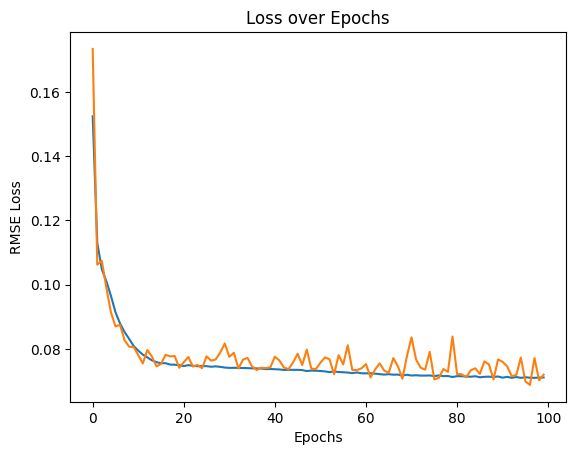

In [9]:
training_data = pd.read_csv('ce889_dataCollectionTraining.csv')
test_data = pd.read_csv('ce889_dataCollectionTest.csv')

training_input_data, training_output_data, test_input_data, test_output_data = normilize(training_data, test_data) 

num_of_neurons_per_layer = [16, 2] 
lr = 0.001
mc = 0.5
min_grad = 3e-4
epochs = 100

net = Net(2, num_of_neurons_per_layer, lr, mc, min_grad)
net.initialize_weights()

net = train_from_csv(net, training_input_data, training_output_data, test_input_data, test_output_data, epochs)

In [10]:
net.save_weights("best_weights.npy")